In [1]:
BATCH_SIZE = 32
MAX_LEN = 512
EMBEDDING_DIM = 300
NUM_CLASSES = 9
NUM_TRAIN = 5893
NUM_TEST = 1474

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN, EMBEDDING_DIM], dtype=tf.float32),
            'Y': tf.FixedLenFeature((NUM_CLASSES,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN, EMBEDDING_DIM])
    
    return X, Y

In [4]:
%%time

x_train, y_train = iterator('train.tfrecord', NUM_TRAIN)
x_test, y_test = iterator('test.tfrecord', NUM_TEST)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 24.8 s, sys: 4.57 s, total: 29.3 s
Wall time: 28.5 s


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 512, 300), (5893, 9), (1474, 512, 300), (1474, 9))

In [6]:
x_train = x_train.reshape(NUM_TRAIN, MAX_LEN * EMBEDDING_DIM)
x_test = x_test.reshape(NUM_TEST, MAX_LEN * EMBEDDING_DIM)

In [52]:
hidden_dims = 256
epochs = 5

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(hidden_dims, 
                activation='relu',
                input_dim=MAX_LEN * EMBEDDING_DIM
               ))
#model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               39321856  
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 2313      
Total params: 39,324,169
Trainable params: 39,324,169
Non-trainable params: 0
_________________________________________________________________


In [54]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [55]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/5
5893/5893 [==============================] - 4s 712us/step - loss: 7.2650 - acc: 0.4293 - val_loss: 6.1311 - val_acc: 0.4905
Epoch 2/5
5893/5893 [==============================] - 3s 529us/step - loss: 3.6349 - acc: 0.6949 - val_loss: 2.5218 - val_acc: 0.6940
Epoch 3/5
5893/5893 [==============================] - 3s 521us/step - loss: 0.8703 - acc: 0.8985 - val_loss: 0.6938 - val_acc: 0.7965
Epoch 4/5
5893/5893 [==============================] - 3s 522us/step - loss: 0.0332 - acc: 0.9900 - val_loss: 0.6145 - val_acc: 0.8202
Epoch 5/5
5893/5893 [==============================] - 3s 519us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.5894 - val_acc: 0.8392
CPU times: user 17.1 s, sys: 7.11 s, total: 24.2 s
Wall time: 17 s


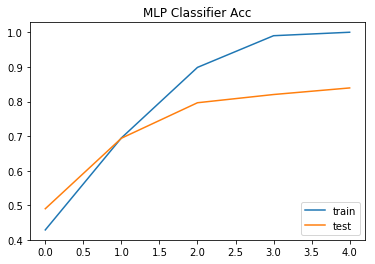

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('MLP Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

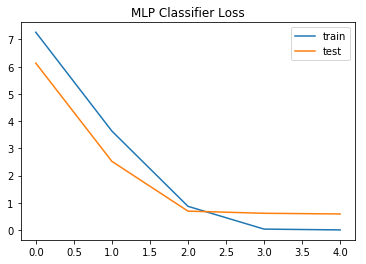

In [59]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('MLP Classifier Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [60]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [61]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.721     0.886     0.795       175
  it-life-hack      0.789     0.825     0.806       154
 kaden-channel      0.856     0.856     0.856       167
livedoor-homme      0.820     0.439     0.571       114
   movie-enter      0.848     0.931     0.888       174
        peachy      0.801     0.701     0.748       184
          smax      0.930     0.930     0.930       186
  sports-watch      0.980     0.890     0.932       163
    topic-news      0.832     0.975     0.897       157

     micro avg      0.839     0.839     0.839      1474
     macro avg      0.842     0.826     0.825      1474
  weighted avg      0.843     0.839     0.834      1474



Normalized confusion matrix
[[0.886 0.    0.006 0.011 0.029 0.057 0.    0.    0.011]
 [0.006 0.825 0.065 0.013 0.013 0.006 0.032 0.    0.039]
 [0.006 0.072 0.856 0.    0.    0.03  0.018 0.    0.018]
 [0.167 0.096 0.053 0.439 0.07  0.114 0.018 0.009 0.035]
 [0.023 0.006 0.011 0.    0.931 0.006 0.    0.006 0.017]
 [0.179 0.011 0.011 0.033 0.049 0.701 0.011 0.    0.005]
 [0.    0.043 0.016 0.    0.    0.011 0.93  0.    0.   ]
 [0.006 0.    0.    0.006 0.018 0.    0.006 0.89  0.074]
 [0.006 0.    0.    0.    0.013 0.    0.    0.006 0.975]]


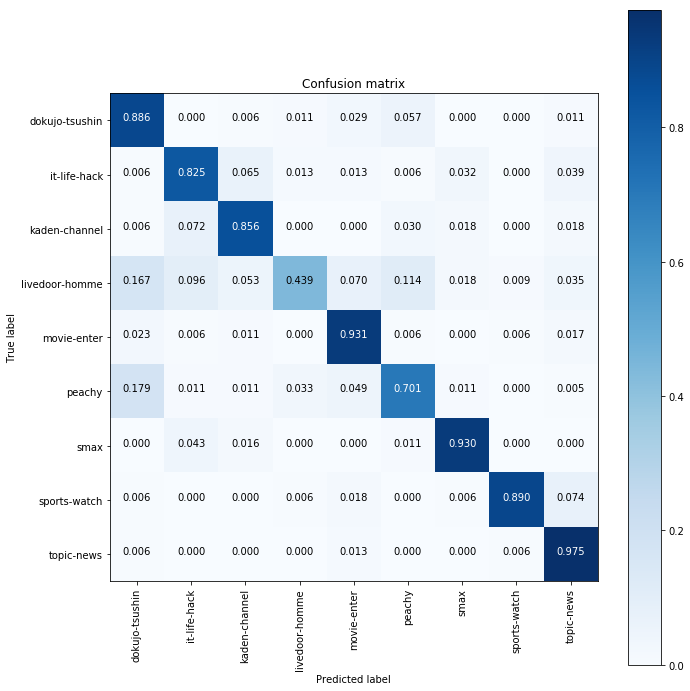

In [62]:
import sys
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)